In [51]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV
from matplotlib import pyplot

pyplot.style.use('default') # para graficos matplotlib
pyplot.rcParams['figure.figsize'] = (10, 8)


from sklearn import metrics
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# pd.options.display.float_format = '{:20,.0f}'.format # suprimimos la notacion cientifica en los outputs

In [66]:
path = 'data/'
features = pd.read_csv(path + 'features.csv')
test = pd.read_csv(path + 'testModified.csv')

In [53]:
x = features.drop(['precio'],1)
y = features['precio']

In [54]:
TUNING  = False

In [55]:
min_samples_split = [10,20,30] # Numero minimo de muestras para splitear nodo
min_samples_leaf = [4,6,8] # Numero minimo de muestras requeridas en cada nodo hoja
bootstrap = [True, False] # Metodo seleccion muestras para entrenar cada arbol
random_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                 "min_child_weight" : [ 1, 3, 5, 7 ],
                 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
                 "subsample" : [0.5,0.6,0.7,0.8,0.9,1],
                 "colsample_bytree" : [0.5,0.6,0.7,0.8,0.9,1],
                 "n_estimators" : [100,200,300,400,500],
              }

In [56]:
tst_sz = 0.3
seed = 139
if (TUNING):
    x, y = shuffle(x, y, random_state=seed)
    xgb = XGBRegressor(njobs=-1)
    xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 15, cv = 5, verbose=100, random_state=42, n_jobs=-1, return_train_score=True)
    xgb_random.fit(x,y)
else:
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=tst_sz,random_state=seed)
    x, y = shuffle(x, y, random_state=seed)
    model = XGBRegressor(njobs=-1, min_child_weight=3, gamma=0.2, learning_rate=0.05, max_depth=12, subsample=0.7, colsample_bytree=0.6, seed=19, n_estimators=400)
    scoring = {'abs_error': 'neg_mean_absolute_error'}
    scores = cross_validate(model, x, y, cv=5, scoring=scoring, return_train_score=True, verbose=30, n_jobs=-1)
    print("MAE :", abs(scores['test_abs_error'].mean()))
    print('Fitting...')
    model.fit(x,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.2min remaining: 16.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 11.3min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.6min finished


MAE : 504558.86225308216
Fitting...


In [57]:
if (TUNING):
    print(xgb_random.best_params_)
    print(xgb_random.best_score_)
    model = xgb_random.best_estimator_

Index(['idzona', 'metrostotales', 'valor m2 idzona', 'metroscubiertos',
       'period', 'Valor dolar', 'valor m2 ciudad', 'antiguedad',
       'habitaciones', 'garages', 'banos', 'poblacion',
       'valor m2 tipodepropiedad', 'titulo len', 'escuelascercanas',
       'descripcion len', 'centroscomercialescercanos', 'Casa', 'Apartamento',
       'Centrosur', 'piscina', 'gimnasio', 'usosmultiples', 'Terreno',
       'Casa en condominio', 'Oeste', 'Noreste', 'Centronorte', 'Este',
       'Sureste', 'Local Comercial', 'Terreno comercial', 'Noroeste',
       'Suroeste', 'Bodega comercial', 'Edificio', 'Oficina comercial',
       'Casa uso de suelo', 'Quinta Vacacional',
       'Inmuebles productivos urbanos', 'Villa', 'Otros', 'Rancho',
       'Nave industrial', 'Terreno industrial', 'Local en centro comercial',
       'Departamento Compartido', 'Duplex', 'Huerta'],
      dtype='object', name='feature')


Text(0, 0.5, 'Feature')

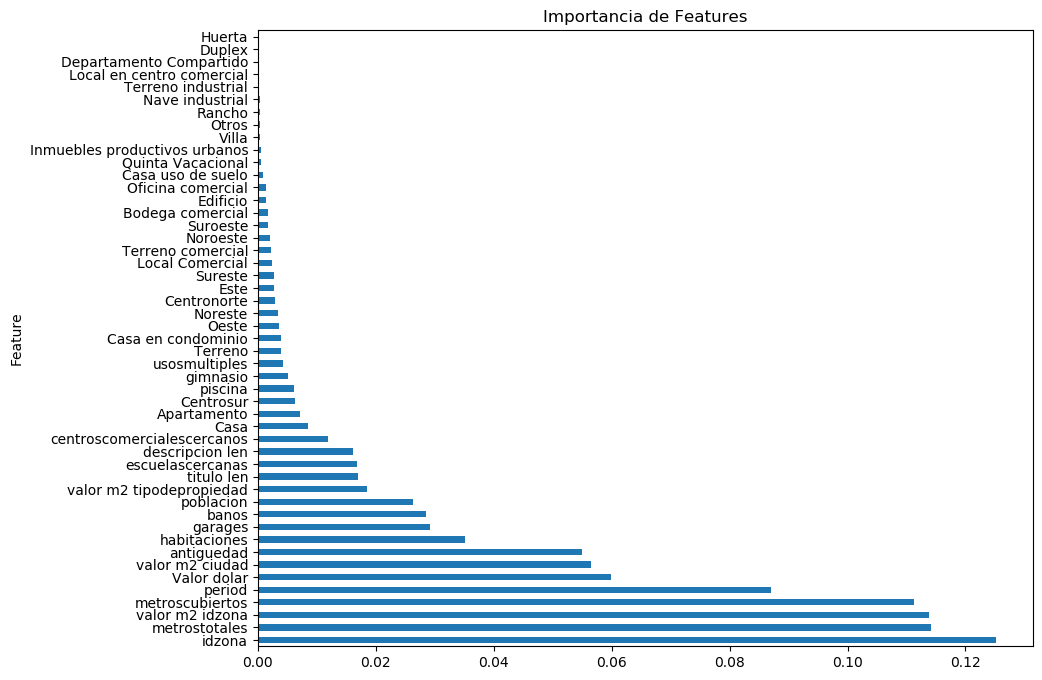

In [63]:
df = pd.DataFrame({'feature':x.columns, 'importance':model.feature_importances_})
df = df.set_index('feature')
df = df.sort_values(by='importance', ascending=False)
# print(xgb_random.best_params_)
print(df.index)  
df.plot(kind='barh', legend=False)
pyplot.title('Importancia de Features')
pyplot.ylabel('Feature')

In [67]:
xgb_predict = model.predict(test.drop(['id'], axis=1))
res = pd.DataFrame(xgb_predict, index=test.id, columns=['precio'])
res = res.rename({'precio':'target'}, axis=1)
res.to_csv("predictions/xgb_predictions.csv", header = True)